# **Comparando diferentes arquitecturas de Redes Neuronales para MNIST**

El problema que se trata de resolver aquí es el de clasificación de imágenes en escala de grises de dígitos escritos a mano (28 píxeles por 28 píxeles), en sus 10 categorías (0 a 9). El conjunto de datos que se va a usar es el conjunto de datos MNIST, un conjunto de datos clásico en la comunidad de aprendizaje automático, que ha existido durante casi tanto tiempo como el campo en sí y se ha estudiado muy intensamente. Es un conjunto de 60,000 imágenes de entrenamiento, más 10,000 imágenes de prueba, ensambladas por el Instituto Nacional de Estándares y Tecnología (NIST en MNIST) en la década de 1980.

Dos técnicas diferentes dentro del campo del Deep Learning van a ser usadas:



1.   Red Neuronal Profunda

2.   Red Neuronal Convolucional



## Descripcción del dataset

La base de datos MNIST (base de datos modificada del Instituto Nacional de Estándares y Tecnología) es una gran base de datos de dígitos escritos a mano que se usa comúnmente para entrenar sistemas de procesamiento de imágenes. La base de datos también se usa ampliamente para el entrenamiento y validación en el campo del aprendizaje automático.

La base de datos MNIST contiene 60,000 imágenes de entrenamiento y 10,000 imágenes de test. Ha habido una serie de artículos científicos sobre intentos de lograr la tasa de error más baja. Un artículo, utilizando un sistema jerárquico de redes neuronales convolucionales, logra obtener una tasa de error en la base de datos MNIST de 0.23%. Los creadores originales de la base de datos mantienen una lista de algunos de los métodos probados en ella. En su artículo original, utilizan una máquina de vectores de soporte para obtener una tasa de error del 0,8%. Un conjunto de datos extendido similar a MNIST llamado EMNIST se ha publicado en 2017, que contiene 240,000 imágenes de entrenamiento y 40,000 imágenes de prueba de dígitos escritos a mano.

## Carga librerías

En primer lugar se cargan las librerías que se consideran necesarias para la realización del ejercicio.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import plot_model

from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

Using TensorFlow backend.


La versión de **keras** que se usará en este notebook es la siguiente 

In [2]:
print("Versión Keras disponible en este notebook: {}".format(keras.__version__))

Versión Keras disponible en este notebook: 2.2.5


Para la carga de datos se hace uso de la siguiente función. En ella se utiliza el módulo propio de Keras, denominado ***dataset***, en el que se encuentran diferentes conjuntos de datos de testing. En este caso se usará el correpondiente al **MNIST**.

In [0]:
(x_train_, y_train_), (x_test_, y_test_) = mnist.load_data()

Las dimensiones de los tensores de entrada **x** resultantes son los siguientes

In [4]:
print('x_train shape:', x_train_.shape)
print('x_test shape:', x_test_.shape)
print(x_train_.shape[0], 'train samples')
print(x_test_.shape[0], 'test samples')

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)
60000 train samples
10000 test samples


Por otro lado, para el target **y** se obtiene la misma información

In [5]:
print('y_train shape:', y_train_.shape)
print('y_test shape:', y_test_.shape)
print(y_train_.shape[0], 'train target')
print(y_test_.shape[0], 'test target')

y_train shape: (60000,)
y_test shape: (10000,)
60000 train target
10000 test target


## Aplicación Red Profunda. Vanilla Network

En este primer apartado se va a realizar un diseño de red neural profunda clásica.



### Carga y tranformación del dataset

Para el uso de una red, unicialmente se han de procesar los datos de entrada y salida. En el apartado anterior se han mostrado las dimensiones de los tensores de entrada y salida y, tal cual como están formateados no son adecuados para el tipo de red que se quiere diseñar.

Para el tratamiento de este problema se ha diseñado una función que realiza las transformaciones pertinentes.

Inicialmente se realiza un redimensionamiento de los tensores de entrada de forma que estos tengan dimension 1, esto es, se tranforman en vectores. Se sabe que las dimensiones de las imágenes indivduales son (28, 28, 1) correspondiendo la primera dimension a la altura en píxeles, la segunda al ancho y la tercera a los canales. Para redimensionarlas se necesita disponer de vectores de dimensión 28x28 que equivale a 748 elementos por vector.

Seguidamente se normalizan los valores de los píxeles dentro del intervalo de 0-1. Se sabe que las imágenes están formateadas en escala de grises y codificadas en 8 bits, por lo que para normalizarlas se ha de dividir por 255 el valor de cada pixel.

Por último, los tensores de salida se redimensionan transformándolos a vectores de dimensión 10 (el número de clases a detectar), de tal forma que todos los valores son nulos excepto aquél que se encuentra en la posición determinada por la clase correspondiente, tomando el valor 1.

In [0]:
def data_ANNNet(x_train, y_train, x_test, y_test):

  prod_dims = np.prod(x_train.shape[1:])
  num_classes = 10

  x_train = x_train.reshape((x_train.shape[0], prod_dims))
  x_train = x_train.astype('float32') / 255

  x_test = x_test.reshape((x_test.shape[0], prod_dims))
  x_test = x_test.astype('float32') / 255

  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255
  
  # convierte clases del target en vectores binarios de dim=10
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  return (x_train, y_train), (x_test, y_test)

Definida la función se transforman los datos originales.

In [0]:
(x_train, y_train), (x_test, y_test) = data_ANNNet(x_train_, y_train_, x_test_, 
                                                   y_test_)

Se comprueba que las dimensiones de las imagenes individuales son las adecuadas.

In [8]:
# input image dimensions
input_shape = x_train.shape[1:]

print("Las dimensiones del tensor de entrada es: {}".format(input_shape))

Las dimensiones del tensor de entrada es: (784,)


### Generación del modelo

El componente básico de las redes neuronales es la "capa", un módulo de procesamiento de datos que puede concebirse como un "filtro" para los datos. Las capas extraen representaciones de los datos introducidos en ellas que resultan ser representaciones más significativas para el problema en cuestión. 

La mayor parte del aprendizaje profundo realmente consiste en encadenar capas simples que implementarán una forma de "destilación de datos" progresiva. Un modelo de aprendizaje profundo es como un tamiz para el procesamiento de datos, hecho de una sucesión de filtros de datos cada vez más refinados: las "capas".

La red a diseñar consistirá en una secuencia de tres capas densas densas, también llamadas "completamente conectadas". La última capa es una capa "softmax" de 10 salidas, lo que significa que devolverá un vector de 10 componentes con la probabilidad de pertenecer a una determinada clase.

Para preparar la red, previo al entrenamiento, se deben elegir tres cosas más, como parte del paso llamado de "compilación":


1. Una función de pérdida: así es como la red podrá medir la performance de la red.

2. Un optimizador: este es el mecanismo a través del cual la red se actualizará en función de los datos que ve y su función de pérdida.

3. Métricas para monitorear durante el entrenamiento y las pruebas. Las métricas a evaluar serán: accuracy, recall, precision y F1. Para las tres métricas finales se definen las funciones que a continuación se muestra.

In [0]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision_ = precision(y_true, y_pred)
    recall_ = recall(y_true, y_pred)
    return 2*((precision_*recall_)/(precision_+recall_+K.epsilon()))

Para la generación del modelo se recurre a la siguiente función. Los parámetros de entrada son:

1. El número de neuronas de cada capa densa. Se recuerda que van a ser tres capas densas y por defecto tendrán 512, 256 y 128 neuronas respectivamente.

2. La función de activación. Por defecto va a ser la función RELU

3. El algoritmo de optimización. Por defecto será "adadelta".

La función tiene como salido el modelo propuesto.


In [0]:
def ANNNet(units=(512, 256, 128), activation='relu', optimizer="adadelta"):

  model = Sequential()
  
  model.add(Dense(units=units[0], activation=activation, 
                  input_shape=input_shape))
  model.add(Dense(units=units[1], activation=activation))
  model.add(Dense(units=units[2], activation=activation))
  
  model.add(Dense(10, activation='softmax'))

  # compilación del modelo
  model.compile(loss="categorical_crossentropy",
                optimizer=optimizer,
                metrics=['accuracy', recall, precision, f1])

  return model

Definida la función, se genera el modelo de red profunda.

In [11]:
modelANN1 = ANNNet()  

### Sumario del modelo

Ejecutando el código siguiente se obtienen las diferentes capas de la red con las dimensiones de sus salidas así como el número de parámetros por las cuales quedan definidas y que deben ser entrenados.

In [12]:
modelANN1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
_________________________________________________________________


Esquematicamente la red queda representada tal como se muestra a continuación.

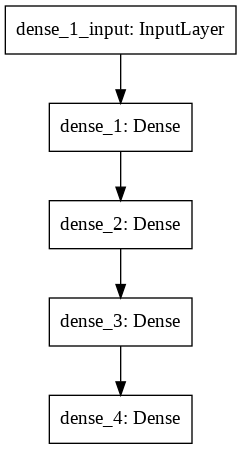

In [13]:
plot_model(modelANN1)

### Entrenamiento del modelo

Una vez definido el modelo, la siguiente fase correspondería al entrenamiento del mismo.

Para ello se definen los parámetros de:

1. BATCH_SIZE: corresponde al número de ejemplares que el algoritmo "verá" de golpe para cada paso de entrenamiento.

2. EPOCHS: el número de veces que el algoritmo verá el data set completo.

En la función de entrenamiento se facilitan, asímismo, los datos test para la estimación de los valores de validación. Esto es necesario para comprobar si el modelo que se está generando es capaz de generalizar de forma adecuada y no sólamente sobre-aprender el data set de entrenamiento.

In [0]:
BATCH_SIZE = 128
EPOCHS = 20

In [15]:
historyANN1 = modelANN1.fit(x_train, y_train,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            verbose=0,
                            validation_data=(x_test, y_test));

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










Realizado el entranemiento se evalúan los datos test.

In [17]:
lossANN1, accANN1, recallANN1, precisionANN1, f1ANN1 = \
                                   modelANN1.evaluate(x_test, y_test, verbose=0)

print('Test loss:', lossANN1)
print('Test accuracy:', accANN1)
print('Test recall:', recallANN1)
print('Test precision:', precisionANN1)
print('Test F1:', f1ANN1)

Test loss: 0.13036021508127452
Test accuracy: 0.959
Test recall: 0.9547
Test precision: 0.9642517358779907
Test F1: 0.9593636312484741


### Curvas de aprendizaje y validación

Una vez realizado el entrenamiento se muestran las curvas de aprendizaje y validación para la función de pérdida y la precisión.

In [18]:
scoresANN1 = pd.DataFrame(historyANN1.history)
scoresANN1

,val_loss,val_acc,val_recall,val_precision,val_f1,loss,acc,recall,precision,f1
0,2.142743,0.2357,0.0000,0.000000,0.000000,2.276177,0.149383,0.000000,0.000000,0.000000
1,1.832099,0.3710,0.2576,0.747681,0.381540,1.933184,0.301183,0.065383,0.566431,0.111944
2,0.843365,0.6999,0.6057,0.776902,0.679644,1.101888,0.600217,0.408150,0.791478,0.523513
3,0.533924,0.8225,0.7887,0.859694,0.822333,0.640846,0.785783,0.720650,0.845217,0.777223
4,0.406191,0.8740,0.8495,0.903775,0.875572,0.477951,0.847900,0.815817,0.882878,0.847856
5,0.363887,0.8892,0.8657,0.914847,0.889378,0.402188,0.875317,0.852200,0.901031,0.875808
6,0.315958,0.9005,0.8837,0.920815,0.901700,0.354626,0.891083,0.871850,0.913381,0.892042
7,0.318045,0.8965,0.8830,0.911361,0.896860,0.315346,0.903733,0.887083,0.923648,0.904923
8,0.254400,0.9205,0.9078,0.936601,0.921892,0.286066,0.912350,0.898150,0.929608,0.913544
9,0.248090,0.9235,0.9122,0.938024,0.924829,0.260460,0.920400,0.907733,0.935928,0.921556


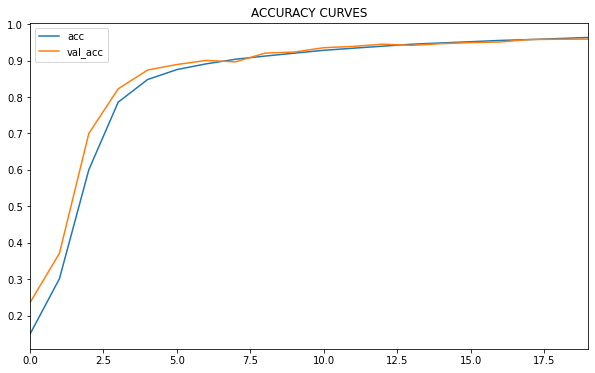

In [19]:
scoresANN1[['acc', "val_acc"]].plot(figsize=(10, 6), title="ACCURACY CURVES");

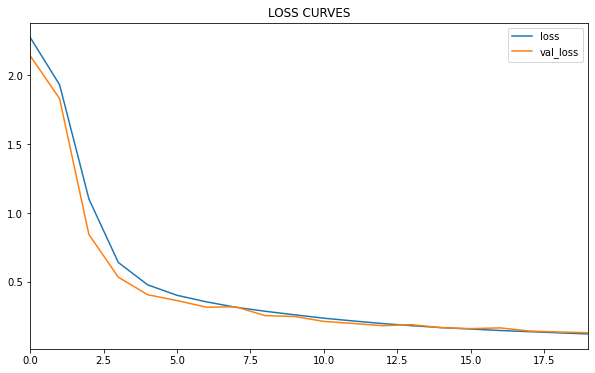

In [20]:
scoresANN1[['loss', "val_loss"]].plot(figsize=(10, 6), title="LOSS CURVES");

Tal como se aprecia en los dos gráficos anteriores, el modelo no presenta problemas de bias ni varianza (over-fitting, under-fitting). Ambas curvas discurren paralelas.

### Predicciones

El método **predict** devuelve un vector con las predicciones para los elementos del conjunto de datos completo. Podemos saber qué clase da la mayor probabilidad de pertenencia mediante la función argmax de Numpy. Que devuelve el índice de la posición que contiene el valor más alto del vector.

A modo de pequeño ejemplo se van a predecir los 20 imágenes elegidas al azar de los datos test y comparar con el valor real. Para ello se genera la siguiente función.

In [0]:
def pred_num(model, n_imgs):
  
  imgs = np.random.randint(0, x_test.shape[0], n_imgs, dtype=int)
  print("Las imágenes a predecir de x_test tienen como índice: {}\n".format(imgs))
  
  y_preds = np.argmax(model.predict(x_test[imgs]), axis=1)
  print("La predicción de la clase sobre esas imágenes da como resultado: {}\n".format(y_preds))

  print("Las clases reales sobre esas imágenes son: {}\n".format(y_test_[imgs]))

  acc_20 = np.equal(y_preds, y_test_[imgs])

  print("Se comprueba que la accuracy para las {:d} imágenes elegidas al azar es de {:.2f}".format(n_imgs, acc_20.sum()/n_imgs))

  return imgs, n_imgs

In [22]:
pred_num(modelANN1, 20)

Las imágenes a predecir de x_test tienen como índice: [4658 1695 7694 8472 2774 6535  838  851 8272 2779 6374 4462 8452 4341
 7848 2983 9247 6526 5628 8468]

La predicción de la clase sobre esas imágenes da como resultado: [7 9 8 4 8 3 4 0 3 0 1 0 4 2 2 9 6 0 3 0]

Las clases reales sobre esas imágenes son: [7 9 8 4 8 3 4 0 3 0 1 0 4 2 2 9 6 0 3 0]

Se comprueba que la accuracy para las 20 imágenes elegidas al azar es de 1.00


(array([4658, 1695, 7694, 8472, 2774, 6535,  838,  851, 8272, 2779, 6374,
        4462, 8452, 4341, 7848, 2983, 9247, 6526, 5628, 8468]), 20)

Por último se presenta la matriz de confusión del modelo. La matriz de confusión es una herramienta que permite la visualización del desempeño de un algoritmo que se emplea en aprendizaje supervisado. Cada columna de la matriz representa el número de predicciones de cada clase, mientras que cada fila representa a las instancias en la clase real. Uno de los beneficios de las matrices de confusión es que facilitan ver si el sistema está confundiendo dos clases.

Para ello se ejecuta la siguiente función que ha sido sacada de la página web de SKLEARN.

In [0]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')

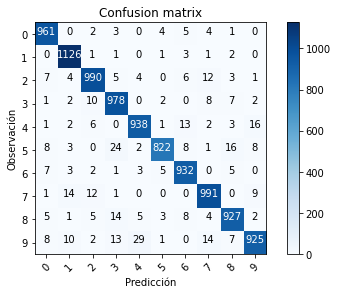

In [24]:
# Predict the values from the validation dataset
Y_pred = modelANN1.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

Finalmente se guarda el modelo.

In [0]:
modelANN1.save("modelANN1.h5")

## Aplicación Red Simple Convolucional. CNN 

En este segundo apartado se va a realizar un diseño de red neural convolucional.

### Carga y transformación de dataset

Para la carga de datos se hace uso de la siguiente función. En ella se utiliza el módulo propio de Keras, denominado ***dataset***, en el que se encuentran diferentes datasets de testing. En este caso se usará el correpondiente al **MNIST**.


Las variables **img_rows** y **img_cols** son usadas para indicar las dimensiones de las imágenes a utilizar. En este caso son 28 pixeles de alto y 28 pixeles de ancho. 

También se realiza el chequeo necesaria por el cual se determina en qué posición del tensor (si no se tiene en cuenta la primera dimensión correspondiente al batch) se encuentra el eje del canal por defecto en keras.  En este caso concreto, keras se encuentra configurado de tal forma que el canal se encuentra en la dimensión 4 del tensor. Sabido esto, se redimensiona el tensor imagen. 

Es necesario normalizar los valores de cada uno de los pixeles de cada imagen tanto en las que van a ser usadas para train como para test. Se recuerda que MNIST se compone de imágenes en escala de grises codificados en 8 bits, esto es, los valores van desde 0 a 255. Por lo tanto, se dividen entre 255 para obtener valores entre 0 y 1.

Por último, ya que la salida del modelo comprende cualquier número comprendido entre 0 y 9 se necesitan 10 clases para la salida. Para la creación de las 10 clases se usa la función **keras.util.to_categorical**. De los 10 valores generados para cada una de las clases, sólamente uno será igual a 1, el resto será igual a 0. Dicho valor único representará unívocamente el valor de la clase representativa del dígito a predecir. 

In [0]:
def data_COVNet(x_train, y_train, x_test, y_test):

  img_rows, img_cols = 28, 28
  num_classes = 10

  if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
  else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255
  
  # convierte clases del target en vectores binarios de dim=10
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  return (x_train, y_train), (x_test, y_test)

Definida la función se ejecuta para obtener los tensores necesarios para los procesos de entrenamiento y test. 

In [0]:
(x_train, y_train), (x_test, y_test) = data_COVNet(x_train_, y_train_, x_test_, 
                                                   y_test_)

Como ejemplo, se muestran las tres primeras imágenes del dataset de entrenamiento.

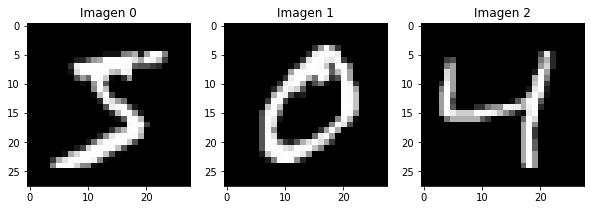

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for img, ax in enumerate(axs):
    ax.imshow(np.squeeze(x_train[img]), cmap="gray")
    ax.set_title("Imagen "+ str(img))
plt.show()

Así mismo se muestran los valores correspondientes del target de las imágenes anteriores.

In [29]:
for i, img in enumerate(np.argmax(y_train[:3], axis=1)):
  print("El valor del target para la imagen {:d} es: {:d}".format(i, img))

El valor del target para la imagen 0 es: 5
El valor del target para la imagen 1 es: 0
El valor del target para la imagen 2 es: 4


In [30]:
# input image dimensions
input_shape = x_train.shape[1:]

print("Las dimensiones del tensor de entrada es: {}".format(input_shape))

Las dimensiones del tensor de entrada es: (28, 28, 1)


### Generación del modelo

Para la generación del modelo se va a emplear la siguiente función por la cual, a través de unos determinados parámetros de entradas, un modelo de red neuronal convolucional, con una determinada arquitectura, es generado.

Los parámetros de entrada de la función son:

1. El número de filtros de las capas convolucionales. Por defecto toma los valores de 32 y 64 respectivamente.

2. El tamano de los filtros: se establece por defecto el tamaño de (3, 3).

3. El tamaño del filtro maxpooling. Por defecto se establece (2, 2).

4. El proporción de conexiones a eliminar en una capa dropout. Por defecto se establece en 0.25.

5. El algotitmo de optimización. Por defecto será el "adadelta". 

6. La función de activación de las capas. Se establece por defecto la función "relu".

La arquitectura del modelo está definida por:

1. La capa 1 es una capa convolucional donde el número de filtros que tiene viene dado por un parámetro de entrada de la función. El resto de los parámetros son los parámetros por defecto.

2. La capa 2 es una capa convolucional donde el número de filtros que tiene viene dado por un parámetro de entrada de la función. El resto de los parámetros son los parámetros por defecto.

3. La capa 3 es una capa MaxPooling que toma el valor máximo de una matriz cuya tamaño viene dado como parámetro de entrada de la función.

4. La capa 4 es una capa Dropout que elimina aleatoriamente las conexiones con la siguiente capa de acuerdo al parámatro rate que se toma como entrada de la función.

5. La capa 5 es una capa Flatten por la que se cambia la dimensión del tensor  entrada a la siguiente capa densa.

6. La capa 6 es una capa Dropout que elimina aleatoriamente las conexiones con la siguiente capa de acuerdo al parámatro rate que se toma como entrada de la función.

7. La capa 7 es una capa de salida densa con 10 neuronas para la correcta clasificación de las diez clases de números. La función de activación es la softmax.

Dentro de la función se encuentra también la compilación del mismo. Por medio de la compilación se definen, entre otras cosas:


1.   La función de pérdida. Loss Function

2.   El algoritmo de optimización. Optimizer

3.   Las métricas usadas para la evaluación del modelo


La función tiene como salido el modelo propuesto.


In [0]:
def CONVNet(filters=[32, 64], kernel_size=(3, 3), pool_size=(2, 2), rate=0.25,
             optimizer="adadelta", activation='relu'):

  model = Sequential()
  model.add(Conv2D(filters=filters[0], kernel_size=kernel_size,
                 activation=activation,
                 input_shape=input_shape))
  model.add(Conv2D(filters=filters[1], kernel_size=kernel_size, 
                   activation=activation))
  model.add(MaxPooling2D(pool_size=pool_size))
  model.add(Dropout(rate=rate))
  model.add(Flatten())
  model.add(Dropout(rate=rate))
  model.add(Dense(10, activation='softmax'))

  # compilación del modelo
  model.compile(loss="categorical_crossentropy",
                optimizer=optimizer,
                metrics=['accuracy', recall, precision, f1])
  
  return model

Ejecutando la función definida generamos el primer modelo convolucional.

In [32]:
modelCONVNet1 = CONVNet();



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Sumario del modelo

Ejecutando el código siguiente se obtienen las diferentes capas de la red con las dimensiones de sus salidas así como el número de parámetros por las cuales quedan definidas y que deben ser entrenados.

In [33]:
modelCONVNet1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

Esquematicamente la red queda representada tal como se muestra a continuación.

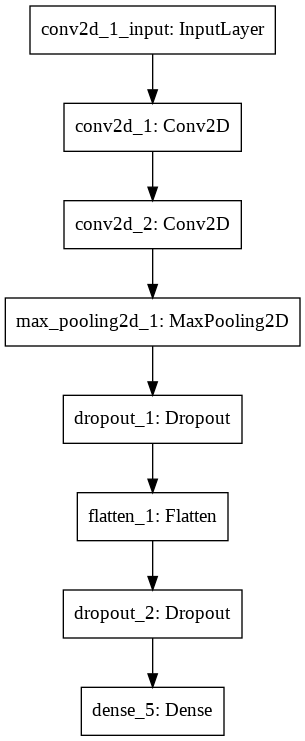

In [34]:
plot_model(modelCONVNet1)

### Entrenamiento del modelo

Una vez definido el modelo, la siguiente fase correspondería al entrenamiento del modelo.

Para ello se definen los parámetros de:

1. BATCH_SIZE: corresponde al número de ejemplares que el algoritmo "verá" de golpe para cada paso de entrenamiento.

2. EPOCHS: el número de veces que el algoritmo verá el data set completo.

En la función de entrenamiento se facilitan asímismo los datos test para la estimación de los valores de validación. Esto es necesario para comprobar si el modelo que se está obteniendo es capaz de generalizar de forma adecuada y no sólamente sobre-aprender el data set de entrenamiento.

In [0]:
BATCH_SIZE = 128
EPOCHS = 20

In [0]:
historyCONVNet1 = modelCONVNet1.fit(x_train, y_train,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=0,
                                    validation_data=(x_test, y_test));

Realizado el entranemiento se evalúan los datos test. Como se aprecia se ha conseguido obtener una precisión, esto es, los ejemplares correctamente clasificados de : 

In [38]:
lossCONVNet1, accCONVNet1, recallCONVNet1, precisionCONVNet1, f1CONVNet1  = \
                              modelCONVNet1.evaluate(x_test, y_test, verbose=0)

print('Test loss:', lossCONVNet1)
print('Test accuracy:', accCONVNet1)
print('Test recall:', recallCONVNet1)
print('Test precision:', precisionCONVNet1)
print('Test F1:', f1CONVNet1)

Test loss: 0.029934956191582023
Test accuracy: 0.9906
Test recall: 0.9904
Test precision: 0.9906903224945068
Test F1: 0.9905428426742554


### Curvas de aprendizaje y validación

Una vez realizado el entrenamiento se muestran las curvas de aprendizaje y validación para la función de pérdida y la precisión.

In [39]:
scoresCONVNet1 = pd.DataFrame(historyCONVNet1.history)
scoresCONVNet1

,val_loss,val_acc,val_recall,val_precision,val_f1,loss,acc,recall,precision,f1
0,0.066541,0.9796,0.9765,0.982052,0.979248,0.241774,0.926450,0.903967,0.941282,0.919500
1,0.052436,0.9845,0.9828,0.986629,0.984703,0.078071,0.976633,0.973683,0.979423,0.976534
2,0.043129,0.9861,0.9845,0.987546,0.986015,0.059335,0.982067,0.980517,0.984277,0.982385
3,0.037321,0.9878,0.9865,0.988866,0.987676,0.049507,0.985450,0.983817,0.987335,0.985566
4,0.038324,0.9871,0.9850,0.988344,0.986659,0.043677,0.986817,0.985500,0.988498,0.986991
5,0.034655,0.9884,0.9877,0.988791,0.988242,0.039613,0.988017,0.987133,0.989411,0.988267
6,0.030983,0.9894,0.9885,0.990669,0.989580,0.036569,0.989200,0.988133,0.990196,0.989160
7,0.034467,0.9879,0.9870,0.989161,0.988074,0.034165,0.989967,0.989283,0.990952,0.990113
8,0.030917,0.9895,0.9888,0.990080,0.989437,0.032383,0.990100,0.989317,0.991214,0.990261
9,0.030151,0.9908,0.9902,0.991484,0.990839,0.029583,0.990867,0.990250,0.991668,0.990956


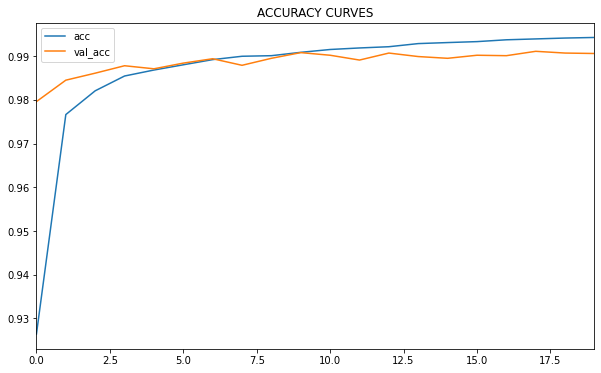

In [40]:
scoresCONVNet1[['acc', "val_acc"]].plot(figsize=(10, 6), title="ACCURACY CURVES");

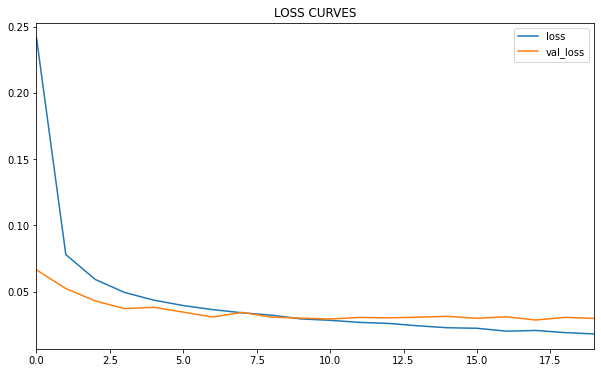

In [41]:
scoresCONVNet1[['loss', "val_loss"]].plot(figsize=(10, 6), title="LOSS CURVES");

Tal como se aprecia en los dos gráficos anteriores, el modelo parece que presenta un ligero problema de over-fitting a partir de la iteración 10. Aún así, habida cuenta de los elevados resultados obtenidos en la accuracy de validación (>99%), el problema no es preocupante. 

Aún así, se podría haber recurrido a la técnica de EarlyStopping para parar las iteraciones una vez visto que las curvas de entrenamiento y validación se separan y así haberse ahorrado 10 iteraciones. Esto se realizaría en Keras introduciendo un objeto Callback de EarlyStopping en la función fit. Al tratarse de un problema sencillo no se llevará a cabo esta técnica. 

### Prediciones

El método **predict** devuelve un vector con las predicciones para los elementos del conjunto de datos completo. Podemos saber qué clase da la mayor probabilidad de pertenencia mediante la función argmax de Numpy. Que devuelve el índice de la posición que contiene el valor más alto del vector.

Como ejemplo se van a predecir los 20 imágenes elegidas al azar de los datos test y comparar con el valor real. 

In [42]:
imgs, n_imgs = pred_num(modelCONVNet1, 20)

Las imágenes a predecir de x_test tienen como índice: [3797 9614 5010 5670 8766 4352 1441 1193 2284 8123 9633 7307 3360 2593
 8265 5250 9673 8317 2760 5786]

La predicción de la clase sobre esas imágenes da como resultado: [5 3 6 7 3 3 8 1 3 6 0 7 7 0 7 2 8 4 9 1]

Las clases reales sobre esas imágenes son: [5 3 6 7 3 3 8 1 3 6 0 7 7 0 7 2 8 4 9 1]

Se comprueba que la accuracy para las 20 imágenes elegidas al azar es de 1.00


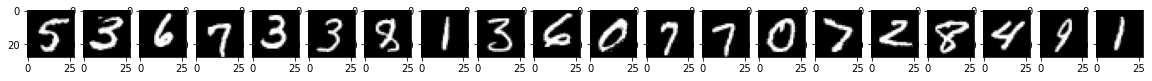

In [43]:
fig, axs = plt.subplots(1, n_imgs, figsize=(20, 3))
for img, ax in zip(imgs, axs):
    ax.imshow(np.squeeze(x_test[img]), cmap="gray")
plt.show()

El siguiente código presenta la matriz de confusión.

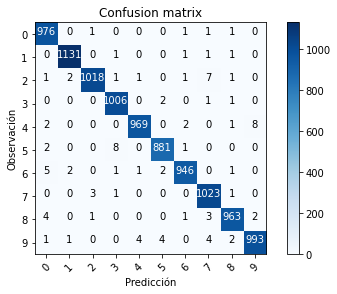

In [44]:
# Predict the values from the validation dataset
Y_pred = modelCONVNet1.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

Finalmente se guarda el modelo.

In [0]:
modelCONVNet1.save("modelCONVNet1.h5")

## Conclusiones

Resumiendo los principales indicadores de los dos modelos realizados:


En cuanto a los resultados **red profunda** se tiene que:

In [53]:
print('Test accuracy:', accANN1)
print('Test recall:', recallANN1)
print('Test precision:', precisionANN1)
print('Test F1:', f1ANN1)

Test accuracy: 0.959
Test recall: 0.9547
Test precision: 0.9642517358779907
Test F1: 0.9593636312484741


mientras que para la **red convolucional** se tiene

In [54]:
print('Test accuracy:', accCONVNet1)
print('Test recall:', recallCONVNet1)
print('Test precision:', precisionCONVNet1)
print('Test F1:', f1CONVNet1)

Test accuracy: 0.9906
Test recall: 0.9904
Test precision: 0.9906903224945068
Test F1: 0.9905428426742554


Si se comparan los resultados anteriores cláramente obtiene mejores resultados la red convolucional. 

En cuanto a la accuracy, la red clasica obtiene valores próximos al 96% mientras que la convolucional de por encima del 99%. 

Destaca, si se observan las curvas de entrenamiento, la rapidez con que la red convolucional adquire valores elevados de la accuracy. Se observa cómo después del tercer epoch  se alcanzan valores superiores al 98% mientras. Lo mismo se podría decir para la función de pérdida pero en cuanto a rapidez de decrecimiento.

En cuanto al resto de métricas (recall, precision, F1) la red convolucional presenta también mejores resultados, presentando valores bajos (sobre el 1%) de ejemplares mal clasificados.

Destacar tambien, en cuanto al número de parámetros de red, que la red convolucional posee un total de **110.986** mientras que, la clásica, tiene **567.434**, esto un cinco veces más parámetros que la primera.

Con todo lo anterior, se aprecian las ventajas de usar arquitecturas basadas en capas convolucionales cuando se trata de resolver problemas relacionados con la imagen, etc.